# Imports And Functions

In [0]:
import pandas as pd
from sklearn import model_selection, preprocessing, metrics
from sklearn.feature_extraction.text import CountVectorizer

from keras.layers import *
from keras.regularizers import l2
from keras.models import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adadelta
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from functools import reduce
from random import shuffle
from math import sqrt
import os
from keras.callbacks import ModelCheckpoint
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from operator import itemgetter
from collections import defaultdict
import seaborn as sns
from functools import reduce
import time
import io

from collections import defaultdict
from gensim.models import KeyedVectors

def time_to_fit(model,X,y):
  start_time = time.time()
  model.fit(X,y)
  return model,time.time()-start_time



In [0]:
def plot_model_history(model_history):
  fig, axs = plt.subplots(1,1,figsize=(15,5))
  axs.plot(range(1,len(model_history['loss'])+1),model_history['loss'])
  axs.plot(range(1,len(model_history['val_loss'])+1),model_history['val_loss'])
  axs.set_title('Model Loss')
  axs.set_ylabel('Loss')
  axs.set_xlabel('Epoch')
  axs.set_xticks(np.arange(1,len(model_history['loss'])+1),len(model_history['loss'])/10)
  axs.legend(['train', 'val'], loc='best')
  plt.show()
  
def plot_results(preds, true):
  print('RMSE: {0:.4f}'.format(rmse(preds, true)))
  fig, axes = plt.subplots(nrows=1, ncols=2)
  ax0, ax1 = axes.flatten()

  ax0.hist(preds, density=True, histtype='bar')
  ax0.set_title('preds')

  ax1.hist(true, density=True, histtype='bar')
  ax1.set_title('true')

  fig.tight_layout()
  plt.show()
  
def add_to_table(row_name, train_preds, val_preds, test_preds, runtime):
  table[row_name] = {}
  table[row_name]['runtime'] = runtime
  
  table[row_name]['Train_RMSE'] = rmse(train_preds, y_train)
  table[row_name]['val_RMSE'] = rmse(val_preds, y_val)
  table[row_name]['Test_RMSE'] = rmse(test_preds, y_test.values)

  table[row_name]['Train_MAE'] = mae(train_preds, y_train)
  table[row_name]['val_MAE'] = mae(val_preds, y_val)
  table[row_name]['Test_MAE'] = mae(test_preds, y_test.values)
  
  
def save_table():
  np.save(path + '/table.npy', table) 

def load_table():
  return np.load(path + '/table.npy').item()

def save_all_distinct_words():
  np.save(path + '/all_distinct_words.npy', all_distinct_words)

def load_all_distinct_words():
  return np.load(path + '/all_distinct_words.npy')

def save_embedding_matrix(name, embedding_matrix):
  np.save(path + '/' + name + '.npy', embedding_matrix)

def load_embedding_matrix(name):
  return np.load(path + '/' + name + '.npy')



# Load Data

In [0]:
path = '.' #'gdrive/My Drive/DL-workshop-3/all'
train_df = pd.read_csv(path + "/train.csv",encoding="ISO-8859-1")
test_df = pd.read_csv(path + "/test.csv",encoding="ISO-8859-1")
attributes_df = pd.read_csv(path + "/attributes.csv",encoding="ISO-8859-1")
product_descriptions_df = pd.read_csv(path + "/product_descriptions.csv",encoding="ISO-8859-1")
solution_df = pd.read_csv(path + "/solution.csv",encoding="ISO-8859-1")

In [0]:
train_df.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [0]:
test_df.head()

,id,product_uid,product_title,search_term,relevance,Usage
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,2.33,Public
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,2.33,Private
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,2.67,Private
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,2.00,Public
6,10,100003,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...,bath and shower kit,2.67,Private


The *solution.csv* file containing the test set targets, meaning the relevance. But there is some samples in the test set that the *solution.csv* file mark as to be ignored. So we will 
remove those sample from the test set.

In [0]:
solution_df = solution_df.loc[solution_df['Usage'] != 'Ignored']

In [6]:
solution_df.head()

,id,relevance,Usage
1,4,2.33,Public
2,5,2.33,Private
3,6,2.67,Private
4,7,2.00,Public
6,10,2.67,Private


In [0]:
test_df = test_df.merge(solution_df,on="id",how='left')[:len(solution_df)].dropna()

In [0]:
test_df.head()

,id,product_uid,product_title,search_term,relevance,Usage
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,2.33,Public
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,2.33,Private
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,2.67,Private
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,2.00,Public
6,10,100003,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...,bath and shower kit,2.67,Private


Now that all the data is loaded correctly we can finally begin the assignment.

# Section 1

## A - Preprocess

In [0]:
col_to_use = ['search_term','product_description']
target = 'relevance'
raw_X_train = train_df.merge(product_descriptions_df,on="product_uid",how='outer')[:74067]
Y_train = raw_X_train[target]
raw_X_train = raw_X_train[col_to_use]

In [0]:
raw_X_test = test_df.merge(product_descriptions_df,on="product_uid",how='outer')[:len(test_df)]
raw_X_test = raw_X_test[col_to_use]
y_test = test_df[target]

We will seperate strings to chars for every sentence.

In [10]:
raw_X_train['search_term'] = raw_X_train['search_term'].map(list)
raw_X_train['product_description'] = raw_X_train['product_description'].map(list)

raw_X_test['search_term'] = raw_X_test['search_term'].map(list)
raw_X_test['product_description'] = raw_X_test['product_description'].map(list)

raw_X_train.head()

,search_term,product_description
0,"[a, n, g, l, e, , b, r, a, c, k, e, t]","[N, o, t, , o, n, l, y, , d, o, , a, n, g, ..."
1,"[l, , b, r, a, c, k, e, t]","[N, o, t, , o, n, l, y, , d, o, , a, n, g, ..."
2,"[d, e, c, k, , o, v, e, r]","[B, E, H, R, , P, r, e, m, i, u, m, , T, e, ..."
3,"[r, a, i, n, , s, h, o, w, e, r, , h, e, a, d]","[U, p, d, a, t, e, , y, o, u, r, , b, a, t, ..."
4,"[s, h, o, w, e, r, , o, n, l, y, , f, a, u, ...","[U, p, d, a, t, e, , y, o, u, r, , b, a, t, ..."


Before splitting to train and validation sets let's have a look of the possible target values.

In [0]:
np.unique(Y_train.values)

array([1.  , 1.25, 1.33, 1.5 , 1.67, 1.75, 2.  , 2.25, 2.33, 2.5 , 2.67,
       2.75, 3.  ])

In [0]:
len(np.unique(Y_train.values))

13

We see that there a limited and small number of possible values, only $13$.<br>
Let's observe if the data is balanced between all the $13$ "classes". 

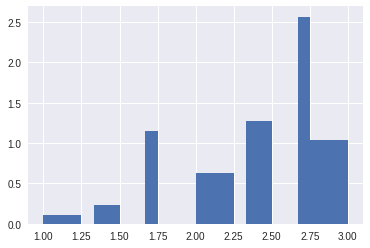

In [0]:
plt.hist(Y_train.values, np.unique(Y_train.values),density=True, histtype='bar')
plt.show()

From the plot above we observe that the data is unbiased between all the $13$ unique value of the target.<br>
We can see that there are the least examples where the target is less then $2$. So while splitting to train and validation set we will make sure that this "classes" is split equally between the sets.

In [0]:
def train_test_split(X, Y, test_size=0.2):
  index_ones = [i for i, x in enumerate(Y) if x <= 1.75]
  index_other = [i for i, x in enumerate(Y) if x > 1.75]
  assert len(index_ones) + len(index_other) == len(Y)
  
  train_size = int(len(X['search_term'])*(1-test_size))
  assert train_size > len(index_ones) // 2
  ones_in_train = len(index_ones) // 2
  other_in_train = train_size - ones_in_train
  
  train_indexs = index_ones[:ones_in_train] + index_other[:other_in_train]
  test_indexs = index_ones[ones_in_train:] + index_other[other_in_train:]
  shuffle(train_indexs)
  shuffle(test_indexs)
  
  x_train = {}
  x_train['search_term'] = np.array([X['search_term'][i] for i in train_indexs])
  x_train['product_description'] = np.array([X['product_description'][i] for i in train_indexs])
  y_train = np.array([Y[i] for i in train_indexs])
  
  x_val = {}
  x_val['search_term'] = np.array([X['search_term'][i] for i in test_indexs])
  x_val['product_description'] = np.array([X['product_description'][i] for i in test_indexs])
  y_val = np.array([Y[i] for i in test_indexs])
  
  return (x_train, y_train), (x_val, y_val)

In [10]:
(raw_x_train, y_train), (raw_x_val, y_val) = train_test_split(raw_X_train, Y_train.values)

print('Train:\n\tx_train[\'search_term\'].shape:{}'.format(raw_x_train['search_term'].shape))
print('\tx_train[\'product_description\'].shape:{}'.format(raw_x_train['product_description'].shape))
print('\ty_train.shape:{}'.format(y_train.shape))
print('Val:\n\tx_val[\'search_term\'].shape:{}'.format(raw_x_val['search_term'].shape))
print('\tx_val[\'product_description\'].shape:{}'.format(raw_x_val['product_description'].shape))
print('\ty_val.shape:{}'.format(y_val.shape))

Train:
	x_train['search_term'].shape:(59253,)
	x_train['product_description'].shape:(59253,)
	y_train.shape:(59253,)
Val:
	x_val['search_term'].shape:(14814,)
	x_val['product_description'].shape:(14814,)
	y_val.shape:(14814,)


In [0]:
one_in_train = len([i for i, x in enumerate(y_train) if x <= 1.75])
one_in_val = len([i for i, x in enumerate(y_val) if x <= 1.75])
print('number of ones in train: {}'.format(one_in_train))
print('number of ones in val: {}'.format(one_in_val))

number of ones in train: 5954
number of ones in val: 5955


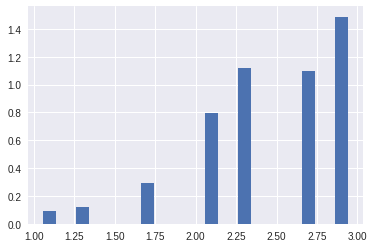

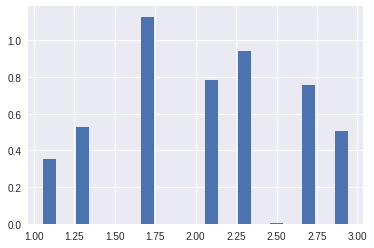

In [0]:
plt.hist(y_train,density=True, histtype='bar', rwidth=0.4)
plt.show()
plt.hist(y_val,density=True, histtype='bar', rwidth=0.4)
plt.show()

In [0]:
all_distinct_chars = raw_x_train['search_term'].tolist() + \
                     raw_x_train['product_description'].tolist() + \
                     raw_x_val['search_term'].tolist() + \
                     raw_x_val['product_description'].tolist()
all_distinct_chars = set(reduce(lambda acc,c: acc.union(set(c)),all_distinct_chars,set()))
print('number of disticnt chars in the train set: {}'.format(len(all_distinct_chars)))

number of disticnt chars in the train set: 94


Notice that we don't expect to encounter an unseen char at the test set.

Now we will tokeniz the data, where ```num_words``` will be $94$ the number of distincts chars.

In [0]:
tokenizer = Tokenizer(num_words=94)
tokenizer.fit_on_texts(list(all_distinct_chars))

In [0]:
X_train = dict()
X_train['search_term'] = tokenizer.texts_to_sequences(raw_x_train['search_term'])
X_train['product_description'] = tokenizer.texts_to_sequences(raw_x_train['product_description'])

X_val = dict()
X_val['search_term'] = tokenizer.texts_to_sequences(raw_x_val['search_term'])
X_val['product_description'] = tokenizer.texts_to_sequences(raw_x_val['product_description'])

X_test = dict()
X_test['search_term'] = tokenizer.texts_to_sequences(raw_X_test['search_term'].values)
X_test['product_description'] = tokenizer.texts_to_sequences(raw_X_test['product_description'].values)

We will check the mean length of description and terms and we will padd every shorter input.

In [0]:
search_terms_lens = int(np.array([len(term) for term in X_train['search_term']] + \
                                 [len(term) for term in X_val['search_term']]).mean())
produc_lens = int(np.array([len(p) for p in X_train['product_description']] + \
                           [len(p) for p in X_val['product_description']]).mean())

print('search terms sequences length: {}'.format(search_terms_lens))
print('product description sequences length: {}'.format(produc_lens))

search terms sequences length: 16
product description sequences length: 730


In [0]:
X_train['search_term'] = pad_sequences(X_train['search_term'],maxlen=search_terms_lens)
X_train['product_description'] = pad_sequences(X_train['product_description'],maxlen=int(produc_lens))

X_val['search_term'] = pad_sequences(X_val['search_term'],maxlen=search_terms_lens)
X_val['product_description'] = pad_sequences(X_val['product_description'],maxlen=int(produc_lens))

X_test['search_term'] = pad_sequences(X_test['search_term'],maxlen=search_terms_lens)
X_test['product_description'] = pad_sequences(X_test['product_description'],maxlen=int(produc_lens))

Now that we finished the pre processing let's take a look of the shape of the train and test sets.

In [0]:
print('X_train[\'search_term\'].shape: {}'.format(X_train['search_term'].shape))
print('X_train[\'product_description\'].shape: {}\n'.format(X_train['product_description'].shape))

print('X_val[\'search_term\'].shape: {}'.format(X_val['search_term'].shape))
print('X_val[\'product_description\'].shape: {}\n'.format(X_val['product_description'].shape))

print('X_test[\'search_term\'].shape: {}'.format(X_test['search_term'].shape))
print('X_test[\'product_description\'].shape: {}'.format(X_test['product_description'].shape))

X_train['search_term'].shape: (59253, 16)
X_train['product_description'].shape: (59253, 730)

X_val['search_term'].shape: (14814, 16)
X_val['product_description'].shape: (14814, 730)

X_test['search_term'].shape: (83447, 16)
X_test['product_description'].shape: (83447, 730)


## B - Siamese Network

The LSTM layer accepts as input three-dimensional tensor. Where the first dimension is the number of the samples. The second dimension is the amount of characters (The "time dimension"). And the third dimension is the representation size of a character, wihch is $1$.<br>
This means that we need to reshape the data.

In [0]:
def my_reshape(X):
  X['search_term'] = X['search_term'].reshape((X['search_term'].shape[0], X['search_term'].shape[1], 1))
  X['product_description'] = X['product_description'].reshape((X['product_description'].shape[0], X['product_description'].shape[1], 1))
  return X

In [0]:
X_train = my_reshape(X_train)
print('X_train search_term shape: {}'.format(X_train['search_term'].shape))
print('X_train product_description shape: {}\n'.format(X_train['product_description'].shape))

X_val = my_reshape(X_val)
print('X_val search_term shape: {}'.format(X_val['search_term'].shape))
print('X_val product_description shape: {}\n'.format(X_val['product_description'].shape))

X_test = my_reshape(X_test)
print('X_test search_term shape: {}'.format(X_test['search_term'].shape))
print('X_train product_description shape: {}'.format(X_test['product_description'].shape))

X_train search_term shape: (59253, 16, 1)
X_train product_description shape: (59253, 730, 1)

X_val search_term shape: (14814, 16, 1)
X_val product_description shape: (14814, 730, 1)

X_test search_term shape: (83447, 16, 1)
X_train product_description shape: (83447, 730, 1)


We notice that the scores at the Home depot product search relevance competition are *RMSE*. So we'll use this metric to determine whether our models do a good job.

In [0]:
def rmse(y1, y2):
  return sqrt(mean_squared_error(y1, y2)) 

Now, we will create a LSTM-NN based on siamese networks archicheture. <br>
We will use negative manhattan distance as similarity function. Pay attention to that this function output is between $0$ to $1$ and our targets range is between $1$ to $3$, so we will use ```norm_to_1_3``` method, as written below, in order to rescale the results.

In [0]:
#hyper params:
lstm_n_hidden = 50
gradient_clipping_norm = 1.25

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

def norm_to_1_3(m):
  return (m * 2) + 1 

We will use CuDNNLSTM which is fast LSTM implementation with CuDNN.



In [0]:
term_input = Input(shape=(search_terms_lens, 1), name='term_input')
product_input = Input(shape=(produc_lens, 1), name='product_input')

shared_lstm = Sequential(name='shared_model')
shared_lstm.add(CuDNNLSTM(lstm_n_hidden))
shared_lstm.add(Dense(128, activation='relu'))

output = Lambda(function=lambda x: norm_to_1_3(exponent_neg_manhattan_distance(x[0], x[1])),
                output_shape=lambda x: (x[0][0], 1),
                name='prediction')([shared_lstm(term_input), shared_lstm(product_input)])

model = Model(inputs=[term_input, product_input], outputs=[output])
optimizer = Adadelta(clipnorm=gradient_clipping_norm)
model.compile(loss='mse', optimizer=optimizer)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
term_input (InputLayer)         (None, 16, 1)        0                                            
__________________________________________________________________________________________________
product_input (InputLayer)      (None, 730, 1)       0                                            
__________________________________________________________________________________________________
shared_model (Sequential)       (None, 128)          17128       term_input[0][0]                 
                                                                 product_input[0][0]              
__________________________________________________________________________________________________
prediction (Lambda)             (None, 1)            0           shared_model[1][0]               
          

In [0]:
cp = ModelCheckpoint(path + '/best_model_weights_char.h5',save_best_only=True)
start_time = time.time()
model_hist = model.fit([X_train['search_term'], X_train['product_description']], 
                       y_train, 
                       validation_data=[[X_val['search_term'], X_val['product_description']], y_val], 
                       epochs=30, batch_size=1024, callbacks=[cp])
end_time = time.time()

Train on 59253 samples, validate on 14814 samples
Epoch 1/30
59253/59253 [==============================] - 15s 260us/step - loss: 0.4702 - val_loss: 0.5022
Epoch 2/30
59253/59253 [==============================] - 11s 188us/step - loss: 0.2627 - val_loss: 0.5025
Epoch 3/30
59253/59253 [==============================] - 11s 188us/step - loss: 0.2469 - val_loss: 0.4618
Epoch 4/30
59253/59253 [==============================] - 11s 189us/step - loss: 0.2420 - val_loss: 0.4477
Epoch 5/30
59253/59253 [==============================] - 11s 189us/step - loss: 0.2405 - val_loss: 0.4495
Epoch 6/30
59253/59253 [==============================] - 11s 189us/step - loss: 0.2391 - val_loss: 0.5429
Epoch 7/30
59253/59253 [==============================] - 11s 190us/step - loss: 0.2389 - val_loss: 0.5322
Epoch 8/30
59253/59253 [==============================] - 11s 190us/step - loss: 0.2378 - val_loss: 0.5216
Epoch 9/30
59253/59253 [==============================] - 11s 190us/step - loss: 0.2373 - val_

In [0]:
model.load_weights(path + '/best_model_weights_char.h5')

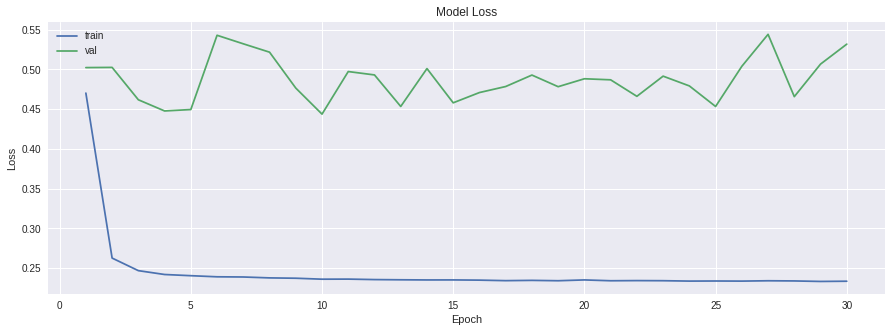

In [0]:
plot_model_history(model_hist.history)

It looks like the model is overfitting the train set. But before making such strong claim let's look how it dose on the test set.

In [0]:
train_preds = model.predict([X_train['search_term'] , X_train['product_description']])
val_preds = model.predict([X_val['search_term'] , X_val['product_description']])
test_preds = model.predict([X_test['search_term'] , X_test['product_description']])

In [0]:
table = load_table()
add_to_table('CharacterLSTM', train_preds, val_preds, test_preds, end_time - start_time)
pd.DataFrame.from_dict(table).T

,Test_MAE,Test_RMSE,Train_MAE,Train_RMSE,runtime,val_MAE,val_RMSE
CharacterLSTM,0.43962,0.529653,0.407273,0.490909,344.96823,0.548179,0.66613


In [0]:
#save_table()

Test
RMSE: 0.5297


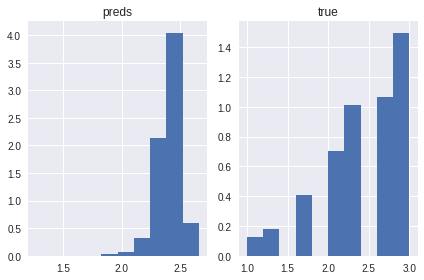

In [0]:
print('Test')
plot_results(test_preds, y_test.values)

We can observe that the *RMSE* score on the test set is pretty low. The best score in the competition is $0.43192$. We can observe that is a small increase of $0.095033$. But mach better result from the *All Ones Benchmark* which is $1.48151$. (We will discuss other benchmarks in the next section).<br>
We can see that the model is failing to predict the relevance the are below $1.5$. And has more focus on the $1.33$ to $2.67$ relevance. (You can see below all the unique values of the relevance).

In [0]:
set(np.hstack((np.unique(y_train), np.unique(y_val))))

{1.0, 1.25, 1.33, 1.5, 1.67, 1.75, 2.0, 2.25, 2.33, 2.5, 2.67, 2.75, 3.0}

## C - Naïve Benchmark Model

For the naïve benchmark model we will use ```CountVectorizer``` in order to incode the character sequence of search term and the product description. After transpormin all the input data each input will be represented by $2$ vectores. This is a "BoW" representacion (more like "bag of character").

In [0]:
raw_data_list = np.hstack((raw_x_train['search_term'], (raw_x_train['product_description'])))
raw_data_list = np.hstack((raw_data_list, raw_x_val['search_term'], (raw_x_val['product_description'])))
my_join = lambda arr: [' '.join(lst) for lst in arr]
raw_data_list = my_join(raw_data_list)

In [0]:
vectorizer = CountVectorizer(analyzer='char')

In [0]:
start_time = time.time()

vectorizer.fit_transform(raw_data_list)

vec_search_term = vectorizer.transform(my_join(raw_x_train['search_term']))
vec_product_description = vectorizer.transform(my_join(raw_x_train['product_description']))

vec_search_term_val = vectorizer.transform(my_join(raw_x_val['search_term']))
vec_product_description_val = vectorizer.transform(my_join(raw_x_val['product_description']))

vec_search_term_test = vectorizer.transform(my_join(raw_X_test['search_term']))
vec_product_description_test = vectorizer.transform(my_join(raw_X_test['product_description']))

end_time = time.time()

In [0]:
x_train = np.stack((vec_search_term.toarray(), vec_product_description.toarray()), axis=1)
x_val = np.stack((vec_search_term_val.toarray(), vec_product_description_val.toarray()), axis=1)
x_test = np.stack((vec_search_term_test.toarray(), vec_product_description_test.toarray()), axis=1)

In [0]:
print('Train:\n\tx_train.shape:{}'.format(x_train.shape))
print('\ty_train.shape:{}'.format(y_train.shape))

print('Val:\n\tx_val.shape:{}'.format(x_val.shape))
print('\ty_val.shape:{}'.format(y_val.shape))

print('Test:\n\tx_test.shape:{}'.format(x_test.shape))
print('\ty_test.shape:{}'.format(y_test.shape))

Train:
	x_train.shape:(59253, 2, 68)
	y_train.shape:(59253,)
Val:
	x_val.shape:(14814, 2, 68)
	y_val.shape:(14814,)
Test:
	x_test.shape:(83447, 2, 68)
	y_test.shape:(83447,)


Now that we have vectores we can compute the distanse between them to find out how closed ther are. To do that we will use the cosine similarity function. Again, pay attention to that the cosine similarity range is $[0, 1]$ and the relevance range is $[1, 3]$, So we will use the ```norm_to_1_3```.<br>

Another thing that we want to point out is, that in this model time consumer is the time it take to pre process the data, and not the training time. So we will mager the count vectorizer fit time and the data transform time in order to compare the runtime with different models.

In [0]:
def square_rooted(x):
  return round(sqrt(sum([a*a for a in x])),3)
 
def cosine_similarity(x,y):
  numerator = sum(a*b for a,b in zip(x,y))
  denominator = square_rooted(x)*square_rooted(y)
  return round(numerator/float(denominator),3)

In [0]:
class NaiveModel():
  def __init__(self):
    pass
  
  def fit(self, x, y):
    pass
  
  def predict(self, x):
    preds = []
    for i in range(x.shape[0]):
      preds.append(norm_to_1_3(cosine_similarity(x[i, 0, :], x[i, 1, :])))
    return np.array(preds)
  
naive_model = NaiveModel()

In [0]:
train_preds = naive_model.predict(x_train)
val_preds = naive_model.predict(x_val)
test_preds = naive_model.predict(x_test)

Test
RMSE: 0.7248


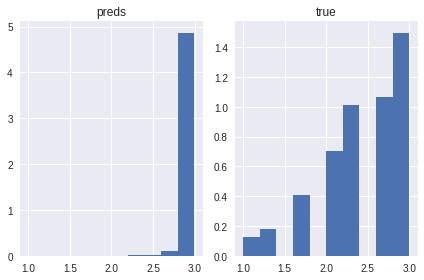

In [0]:
print('Test')
plot_results(test_preds, y_test.values)

In [0]:
add_to_table('naïve_model(1C)', train_preds, val_preds, test_preds, end_time - start_time)
pd.DataFrame.from_dict(table).T

,Test_MAE,Test_RMSE,Train_MAE,Train_RMSE,runtime,val_MAE,val_RMSE
CharacterLSTM,0.43962,0.529653,0.407273,0.490909,344.968230,0.548179,0.666130
naïve_model(1C),0.53757,0.724760,0.507341,0.675441,96.343572,0.903160,1.058353


In [0]:
#save_table()

We can observed that the model is predicting almost all the time that same relevance which is $3$. First, this explain why the *RMSE* score over the test set is higher the ```CharacterLSTM``` model.<br>
Second, this means that most of the cosine similarity values are 1 (```norm_to_1_3```$(1)=3$). This tell us the most of pairs of vectors representing the the input are very close.<br>
From this we conclude that this model is to naïve. So we will try to use a different model as a Naïve benchmark. We will try to predict the mean of the train relevance all the time. We expect this change to reduce *RMSE* score.

In [0]:
class NaiveModel_mean():
  def __init__(self):
    self.train_mean = -1;
  
  def fit(self, x, y):
    self.train_mean = round(y.mean(), 2)
  
  def predict(self, x):
    if self.train_mean == -1:
      print('please fit the model before making a prediction.')
    preds = []
    for i in range(x.shape[0]):
      preds.append(self.train_mean)
    return np.array(preds)
  
naive_model = NaiveModel_mean()

In [0]:
strat_time = time.time()
naive_model.fit(x_train, y_train)
end_time = time.time()

In [0]:
print('The relevent mean of the train set: {}'.format(naive_model.train_mean))

The relevent mean of the train set: 2.46


In [0]:
train_preds = naive_model.predict(x_train)
val_preds = naive_model.predict(x_val)
test_preds = naive_model.predict(x_test)

Test
RMSE: 0.5311


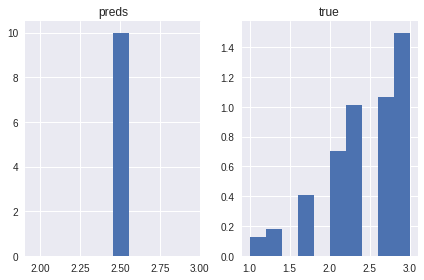

In [0]:
print('Test')
plot_results(test_preds, y_test.values)

In [0]:
add_to_table('naïve_model_mean(1C)', train_preds, val_preds, test_preds, end_time - start_time)
pd.DataFrame.from_dict(table).T

,Test_MAE,Test_RMSE,Train_MAE,Train_RMSE,runtime,val_MAE,val_RMSE
CharacterLSTM,0.439620,0.529653,0.407273,0.490909,344.968230,0.548179,0.666130
naïve_model(1C),0.537570,0.724760,0.507341,0.675441,96.343572,0.903160,1.058353
naïve_model_mean(1C),0.440792,0.531097,0.408442,0.489216,106.922296,0.583952,0.706428


In [0]:
#save_table()

We can see our expectation are true. The ```NaiveModel_mean``` model did perform better and have lower *RMSE* score than the previous naive model over the train, validation and test sets.<br>
In addition, we can observed that the difference between the *RMSE* scores of the ```NaiveModel_mean``` model and the ```CharacterLSTM``` model is very small and almost meaningless: $0.01..$ on test set.<br>
Therefore, we think that the model we made in the previous section ($1B$) is a good model.

## D - Feature Extractor

For the feature extractor we will use the ```CharacterLSTM``` model from section $1B$. We choose this model.

First we need to take the data that is organized in such a way that the model from section 
$1B$ can be received as input.

In [0]:
print('Train:\n\tx_train[\'search_term\'].shape:{}'.format(X_train['search_term'].shape))
print('\tx_train[\'product_description\'].shape:{}'.format(X_train['product_description'].shape))
print('\ty_train.shape:{}'.format(y_train.shape))
print('Val:\n\tx_val[\'search_term\'].shape:{}'.format(X_val['search_term'].shape))
print('\tx_val[\'product_description\'].shape:{}'.format(X_val['product_description'].shape))
print('\ty_val.shape:{}'.format(y_val.shape))

Train:
	x_train['search_term'].shape:(59253, 16, 1)
	x_train['product_description'].shape:(59253, 730, 1)
	y_train.shape:(59253,)
Val:
	x_val['search_term'].shape:(14814, 16, 1)
	x_val['product_description'].shape:(14814, 730, 1)
	y_val.shape:(14814,)


Second, we will create the same model as in Section $1B$, and load the trained weights. <br>After that we will cut the last layer in the model. In order to use it's output as features to a ML model.<br>
Notice that the after we cut the last layer we left with $2$ ouputs due to the siamese network architecture. So we will add a ```concatenate``` layer.

In [0]:
term_input = Input(shape=(search_terms_lens, 1), name='term_input')
product_input = Input(shape=(produc_lens, 1), name='product_input')

shared_lstm = Sequential(name='shared_model')
shared_lstm.add(CuDNNLSTM(lstm_n_hidden))
shared_lstm.add(Dense(128, activation='relu'))

output = concatenate([shared_lstm(term_input), shared_lstm(product_input)])

fe_model = Model(inputs=[term_input, product_input], outputs=[output])
fe_model.load_weights(path + '/best_model_weights_char.h5')

optimizer = Adadelta(clipnorm=gradient_clipping_norm)
fe_model.compile(loss='mse', optimizer=optimizer)
fe_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
term_input (InputLayer)         (None, 16, 1)        0                                            
__________________________________________________________________________________________________
product_input (InputLayer)      (None, 730, 1)       0                                            
__________________________________________________________________________________________________
shared_model (Sequential)       (None, 128)          17128       term_input[0][0]                 
                                                                 product_input[0][0]              
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 256)          0           shared_model[1][0]               
          

Now we will produce the new features for the training set, validation set and test set.

In [0]:
train_features = fe_model.predict([X_train['search_term'] , X_train['product_description']])
val_features = fe_model.predict([X_val['search_term'] , X_val['product_description']])
test_features = fe_model.predict([X_test['search_term'] , X_test['product_description']])

### First model - Random Forest

In [0]:
RM_model = RandomForestRegressor()
start_time = time.time()
RM_model.fit(train_features, y_train)
end_time = time.time()

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
train_preds = RM_model.predict(train_features)
val_preds = RM_model.predict(val_features)
test_preds = RM_model.predict(test_features)

In [0]:
add_to_table('RandomForest(1D)', train_preds, val_preds, test_preds, end_time - start_time)
pd.DataFrame.from_dict(table).T

,Test_MAE,Test_RMSE,Train_MAE,Train_RMSE,runtime,val_MAE,val_RMSE
CharacterLSTM,0.439620,0.529653,0.407273,0.490909,344.968230,0.548179,0.666130
RandomForest(1D),0.439696,0.542474,0.160088,0.218505,61.621884,0.530739,0.650805
naïve_model(1C),0.537570,0.724760,0.507341,0.675441,96.343572,0.903160,1.058353
naïve_model_mean(1C),0.440792,0.531097,0.408442,0.489216,106.922296,0.583952,0.706428


In [0]:
#save_table()

We can observe that the ```RandomForest(1D)``` model does not exceed the ```CharacterLSTM```. In fact it does a bit worse in the test set $0.54...$ *RMSE* score compared to $0.52...$.<br>
In addition we can see that the ```RandomForest(1D)``` is performing mach better on the train $0.16...$ compared to all the other model.

Test
RMSE: 0.5425


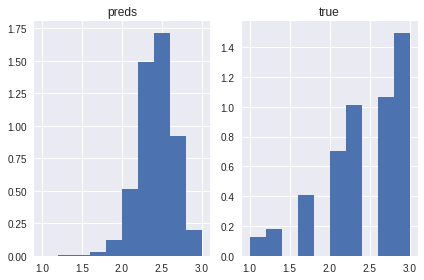

In [0]:
print('Test')
plot_results(test_preds, y_test.values)

In the plot above we can see that the model is trying to predict a bigger range of targets than previous models. In fact it's predictions range is truly $[1, 3]$ as shows below. Which mean that the model did succeed at learning something new from the new features.

In [0]:
print('pretiction: min {}, max {}'.format(test_preds.min(), test_preds.max()))

pretiction: min 1.0, max 3.0


### Second model - LightGBM

Now we will try to use the LightGBM model with the new features.

In [0]:
params = {
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 13,
    'learning_rate': 0.05,
    'verbose': 0
}
lgb_train = lgb.Dataset(train_features, y_train)
lgb_val = lgb.Dataset(val_features, y_val)

In [0]:
start_time = time.time()
gbm = lgb.train(params, lgb_train, valid_sets=lgb_val)
end_time = time.time()

[1]	valid_0's l1: 0.585846	valid_0's l2: 0.502216
[2]	valid_0's l1: 0.58541	valid_0's l2: 0.501504
[3]	valid_0's l1: 0.584948	valid_0's l2: 0.500813
[4]	valid_0's l1: 0.58454	valid_0's l2: 0.500203
[5]	valid_0's l1: 0.584112	valid_0's l2: 0.499564
[6]	valid_0's l1: 0.583697	valid_0's l2: 0.498961
[7]	valid_0's l1: 0.583335	valid_0's l2: 0.498447
[8]	valid_0's l1: 0.582972	valid_0's l2: 0.497925
[9]	valid_0's l1: 0.582707	valid_0's l2: 0.497578
[10]	valid_0's l1: 0.582442	valid_0's l2: 0.497223
[11]	valid_0's l1: 0.582125	valid_0's l2: 0.496763
[12]	valid_0's l1: 0.581769	valid_0's l2: 0.496275
[13]	valid_0's l1: 0.581531	valid_0's l2: 0.495973
[14]	valid_0's l1: 0.581207	valid_0's l2: 0.495507
[15]	valid_0's l1: 0.580909	valid_0's l2: 0.495092
[16]	valid_0's l1: 0.580613	valid_0's l2: 0.494703
[17]	valid_0's l1: 0.580411	valid_0's l2: 0.494451
[18]	valid_0's l1: 0.580137	valid_0's l2: 0.494112
[19]	valid_0's l1: 0.579896	valid_0's l2: 0.493815
[20]	valid_0's l1: 0.579664	valid_0's l2: 

In [0]:
train_preds = gbm.predict(train_features, num_iteration=gbm.best_iteration)
val_preds = gbm.predict(val_features, num_iteration=gbm.best_iteration)
test_preds = gbm.predict(test_features, num_iteration=gbm.best_iteration)

In [0]:
add_to_table('LightGBM(1D)', train_preds, val_preds, test_preds, end_time - start_time)
pd.DataFrame.from_dict(table).T

,Test_MAE,Test_RMSE,Train_MAE,Train_RMSE,runtime,val_MAE,val_RMSE
CharacterLSTM,0.439620,0.529653,0.407273,0.490909,344.968230,0.548179,0.666130
LightGBM(1D),0.431425,0.524175,0.392092,0.473328,2.015421,0.573347,0.695735
RandomForest(1D),0.439696,0.542474,0.160088,0.218505,61.621884,0.530739,0.650805
naïve_model(1C),0.537570,0.724760,0.507341,0.675441,96.343572,0.903160,1.058353
naïve_model_mean(1C),0.440792,0.531097,0.408442,0.489216,106.922296,0.583952,0.706428


In [0]:
#save_table()

Test
RMSE: 0.5242


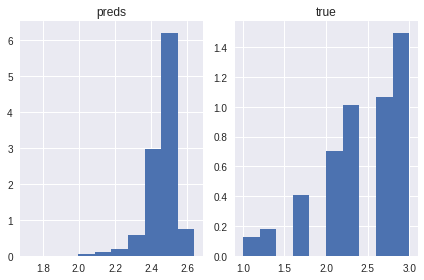

In [0]:
print('Test')
plot_results(test_preds, y_test.values)

We can see that the LigthGBM model has the lower *RMSE* score on the tets set $0.524..$. Like the previous model it perform poorly on the valitistion set, but has the best performance on the test sets.<br>
In addition, it's has the fastes runtime overall, only $2.015$ seconds. We think it is because of the fact that this model need to handle smaller input representation, $256$ features per sample compert to $16 + 730$. This also explain why the runtime of the ```CharacterLSTM``` model is vary long and, the runtime of the```Random Forest(1D)``` is only ~$1$ minute.

In [0]:
print('pretiction: min {}, max {}'.format(round(test_preds.min(), 2), round(test_preds.max(), 2)))

pretiction: min 1.72, max 2.64


Although this model produces better results, it can not predict the entire range.

# Section 2

First of all, we need to return the raw data to be words, and not chars.

In [0]:
my_join = lambda chars: ''.join(chars)

X_train = dict()
X_train['search_term'] = np.array([my_join(st) for st in raw_x_train['search_term']])
X_train['product_description'] = np.array([my_join(pd) for pd in raw_x_train['product_description']])

X_val = dict()
X_val['search_term'] = np.array([my_join(st) for st in raw_x_val['search_term']])
X_val['product_description'] = np.array([my_join(pd) for pd in raw_x_val['product_description']])

X_test = dict()
X_test['search_term'] = raw_X_test['search_term'].map(my_join)
X_test['product_description'] = raw_X_test['product_description'].map(my_join)

## A - Preprocess

Now we will repate the some process from section $1 A$. Such that at the end of the process we will have train, validation and test sets that contain sequence of words.

First, we need to find all the distinct words.

In [0]:
all_distinct_words = X_train['search_term'].tolist() + X_train['product_description'].tolist() + \
                     X_val['search_term'].tolist() + X_val['product_description'].tolist()
all_distinct_words = set(reduce(lambda acc,c: acc.union(set(c.split())),all_distinct_words,set()))
print('number of disticnt words in the train set: {:,}'.format(len(all_distinct_words)))

number of disticnt words in the train set: 291,939


In [0]:
# all_distinct_words = np.array(list(all_distinct_words))
# save_all_distinct_words()

In [0]:
all_distinct_words = load_all_distinct_words()

Second, we want to refer to character-combinations such as: "¾", "90°", "#SC" as words. So in order to that we will not filter character such as "/", "@", "*" etc, while fitting the tokenizer. Let's look a the words that contain character the will be filtered if use the default ```filters``` definition of the tokenizer.

In [0]:
chars = set('<|=]`:~}(#>+".?_\%);/$,{@^*&[-!')
for word in all_distinct_words:
  intersection = chars.intersection(set(word))
  if len(chars.intersection(set(word))) > 0:
    print(word)
    chars = chars - set(intersection.pop())

unloaded.2
TV's,
systemZero-flush
(18-1/4
larger)Made
fulfilled;
180FDVD/CD
HomeDepot@BrownJordan.com,
$289.00
cubePlating:
500%Bearings
110dB+
constructionZinc-plated#10-24Coarse
0_-360_.Pre-installed
Solar!Also
finish"Matchless"
href="http://www.homedepot.com/c/SPC_BRD_PA_Wagner"
SHAKE&SHIP
R.V.s**Not
[40F
lumber?
Info<img
Applianceslt/>A
s.\75
[Bifenthrin]
Barrel`s
installations}
m~m18
{required
kgf/cm^2,


We can se that we wouldn't wont to split words that contain $\$$ because we think this can be informative relatively to the context of the dataset. In addition we would like to filter $<, >$ because we can observe *HTML* tags and we think that the model will not benefit from them. We thong that is because probably the *HTML* tags are representing a format that will repeat in all the inputs and we do not want to attribute much importance to it.

In [0]:
tokenizer = Tokenizer(num_words=len(all_distinct_words), filters='";(),+-.=!?[]_<>{}^~:')
tokenizer.fit_on_texts(list(all_distinct_words))

X_train['search_term'] = tokenizer.texts_to_sequences(X_train['search_term'])
X_train['product_description'] = tokenizer.texts_to_sequences(X_train['product_description'])

X_val['search_term'] = tokenizer.texts_to_sequences(X_val['search_term'])
X_val['product_description'] = tokenizer.texts_to_sequences(X_val['product_description'])

X_test['search_term'] = tokenizer.texts_to_sequences(X_test['search_term'])
X_test['product_description'] = tokenizer.texts_to_sequences(X_test['product_description'])

Let's observed some word that contain the not filter characters:

In [0]:
not_filter = set('\|&%/$*#@`')
for word in tokenizer.word_index.keys():
  intersection = not_filter.intersection(set(word))
  if len(not_filter.intersection(set(word))) > 0:
    print(word)
    not_filter = not_filter - set(intersection.pop())

1/2
100%
$1
#1
*
support@weberstephen
t&g
hrs\day
barrel`s


We can see that by not filtering some of the character we can observed words like: $"\$1,"$ $"1/2"$, $"support@weberstephen"$ and more.

In [16]:
search_terms_lens = int(np.array([len(term) for term in X_train['search_term']]).mean())
produc_lens = int(np.array([len(p) for p in X_train['product_description']]).mean())

print('search terms sequences length: {}'.format(search_terms_lens))
print('product description sequences length: {}'.format(produc_lens))

search terms sequences length: 3
product description sequences length: 142


In [0]:
X_train['search_term'] = pad_sequences(X_train['search_term'],maxlen=search_terms_lens)
X_train['product_description'] = pad_sequences(X_train['product_description'],maxlen=int(produc_lens))

X_val['search_term'] = pad_sequences(X_val['search_term'],maxlen=search_terms_lens)
X_val['product_description'] = pad_sequences(X_val['product_description'],maxlen=int(produc_lens))

X_test['search_term'] = pad_sequences(X_test['search_term'],maxlen=search_terms_lens)
X_test['product_description'] = pad_sequences(X_test['product_description'],maxlen=int(produc_lens))

In [0]:
print('X_train[\'search_term\'].shape: {}'.format(X_train['search_term'].shape))
print('X_train[\'product_description\'].shape: {}\n'.format(X_train['product_description'].shape))

print('X_val[\'search_term\'].shape: {}'.format(X_val['search_term'].shape))
print('X_val[\'product_description\'].shape: {}\n'.format(X_val['product_description'].shape))

print('X_test[\'search_term\'].shape: {}'.format(X_test['search_term'].shape))
print('X_test[\'product_description\'].shape: {}'.format(X_test['product_description'].shape))

X_train['search_term'].shape: (59253, 3)
X_train['product_description'].shape: (59253, 142)

X_val['search_term'].shape: (14814, 3)
X_val['product_description'].shape: (14814, 142)

X_test['search_term'].shape: (83447, 3)
X_test['product_description'].shape: (83447, 142)


Now we will use a pre-trained word2vec vectors in order to construct an embedding matrix. To do this we will use the *GoogleNews-vectors-negative300.bin* file. This mean the embedding size is $300$.<br>
We will contrast $1$ embedding matrix for the ```search_term``` and for the ```product_description```. This means that we will have the same representation for the same word that appears in ```search_term``` and once in ```product_description```.

In [0]:
def make_embedding_matrix(pre_train_embedding):
  embedding_matrix = np.empty((len(tokenizer.word_index), 300))
  for word, i in tokenizer.word_index.items():
    if word in pre_train_embedding:
      if type(pre_train_embedding) == dict:
        embedding_matrix[i] = pre_train_embedding[word]
      else:  
        embedding_matrix[i] = pre_train_embedding.get_vector(word)
  return embedding_matrix

In [0]:
pre_train_embedding_GoogleNews = KeyedVectors.load_word2vec_format(path + '/GoogleNews-vectors-negative300.bin', binary=True)
embedding_matrix_GoogleNews = make_embedding_matrix(pre_train_embedding_GoogleNews)
del pre_train_embedding_GoogleNews

In [0]:
def print_num_of_zero_rows(embedding_matrix):
  num_of_zero_rows = 0
  for i in range(embedding_matrix.shape[0]):
    if reduce(lambda cur, acc: acc and cur, np.equal(embedding_matrix[i], np.zeros((300,))), True):
      num_of_zero_rows += 1
  print('Total number of words that do not have an embedding: {:,}'.format(num_of_zero_rows))
  print('Total number of words: {:,}'.format(len(tokenizer.word_index)))

In [0]:
print_num_of_zero_rows(embedding_matrix_GoogleNews)

Total number of words that do not have an embedding: 149,567
Total number of words: 176,170


We can see that most of the words in our data are missing from the pre trained embedding vectors. So we will try to use a different embedding vectors.<br>
We will use the *fastText* pre-trained word vectors that contain $1$ million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset ($16B$ tokens). <br>
Since it is a lot of vector we do not want to load all of them at once. So we will load all the necessary vectors, those who represent words that left after the pre process of the tokenizer.<br>
Notice that in order to save memory space, we load those vectores as a generator and after we make sure we need them we activates the generator in order to load the necessary vectors in to the embedding matrix.

In [0]:
def load_necessary_vectors(fname):
  fin = io.open(path + '/' + fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
  n, d = map(int, fin.readline().split())
  assert d == 300
  data = {}
  for line in fin:
    tokens = line.rstrip().split(' ')
    if tokens[0] in tokenizer.word_index.keys():
      data[tokens[0]] = tokens[1:]
  return data

In [0]:
pre_train_embedding_fastText = load_necessary_vectors('wiki.es.vec')
embedding_matrix_fastText = make_embedding_matrix(pre_train_embedding_fastText)
del pre_train_embedding_fastText
print_num_of_zero_rows(embedding_matrix_GoogleNews)

Total number of words that do not have an embedding: 149,567
Total number of words: 176,170


We can see that with the *fastText* we get the same numbers of vectors. Let's find out if all of them are for the same words.

In [0]:
indexs = []
zero_arr = np.zeros((300,))
for i in range(embedding_matrix_fastText.shape[0]):
  is_zero_GoogleNews_i = reduce(lambda cur, acc: acc and cur, np.equal(embedding_matrix_GoogleNews[i], zero_arr), True)
  is_zero_fastText_i = reduce(lambda cur, acc: acc and cur, np.equal(embedding_matrix_fastText[i], zero_arr), True)
  if (is_zero_GoogleNews_i and not is_zero_fastText_i) or (not is_zero_GoogleNews_i and is_zero_fastText_i):
     indexs.append(i)
len(indexs)

9477

We can see that ther are $9,477$ vectores one of the pre-trains vectors sets has and the other not. So maybe we can combain the two embedding matrices. Let's check if there are some similarity between the two pre-trained vectors sets.

In [0]:
_indexs = []
zero_arr = np.zeros((300,))
for i in range(embedding_matrix_fastText.shape[0]):
  is_zero_GoogleNews_i = reduce(lambda cur, acc: acc and cur, np.equal(embedding_matrix_GoogleNews[i], zero_arr), True)
  is_zero_fastText_i = reduce(lambda cur, acc: acc and cur, np.equal(embedding_matrix_fastText[i], zero_arr), True)
  if not is_zero_GoogleNews_i and not is_zero_fastText_i:
    if reduce(lambda cur, acc: acc and cur, np.equal(embedding_matrix_GoogleNews[i], embedding_matrix_fastText[i]), True):
      _indexs.append(i)
len(_indexs)

0

Clearly there is no similarity at all. So for the next section we we will try train $3$ models and see which one performs best.
1. A model that use the ```embedding_matrix_GoogleNews``` without train it.
2. A model that use the ```embedding_matrix_fastText``` without train it.
3. A model that use the a combination of the two and train on it.

Notice that we will not keep the zero vectors, instead we will make random vectors.

In [0]:
embedding_matrix_comb = (np.random.rand(len(tokenizer.word_index), 300) - 0.5) / 5.0
for i in indexs:
  is_zero_GoogleNews_i = reduce(lambda cur, acc: acc and cur, np.equal(embedding_matrix_GoogleNews[i], zero_arr), True)
  is_zero_fastText_i = reduce(lambda cur, acc: acc and cur, np.equal(embedding_matrix_fastText[i], zero_arr), True)
  if not is_zero_GoogleNews_i:
    embedding_matrix_comb[i] = embedding_matrix_GoogleNews[i]
  elif not is_zero_fastText_i:
    embedding_matrix_comb[i] = embedding_matrix_fastText[i]
save_embedding_matrix('embedding_matrix_comb', embedding_matrix_comb)

In [0]:
for i in indexs:
  is_zero_GoogleNews_i = reduce(lambda cur, acc: acc and cur, np.equal(embedding_matrix_GoogleNews[i], zero_arr), True)
  is_zero_fastText_i = reduce(lambda cur, acc: acc and cur, np.equal(embedding_matrix_fastText[i], zero_arr), True)
  if is_zero_GoogleNews_i:
    embedding_matrix_GoogleNews[i] = (np.random.rand(300) - 0.5) / 5.0
  elif is_zero_fastText_i:
    embedding_matrix_fastText[i] = (np.random.rand(300) - 0.5) / 5.0
    
save_embedding_matrix('embedding_matrix_GoogleNews', embedding_matrix_GoogleNews)
save_embedding_matrix('embedding_matrix_fastText', embedding_matrix_fastText)

In [0]:
embedding_matrix_comb = load_embedding_matrix('embedding_matrix_comb')
embedding_matrix_GoogleNews = load_embedding_matrix('embedding_matrix_GoogleNews')
embedding_matrix_fastText = load_embedding_matrix('embedding_matrix_fastText')

## B - Siamese Network

We will use the same model architecture from section $1B$ with an addition of embedding layer between the input layer and the LSTM layer.<br>
Notice that the embedding layer with the right ```input_length``` parameter will reshape the input to a $3$ dimensional tensor.


In [0]:
def get_model(embedding_matrix):
  # Input
  term_input = Input(shape=(search_terms_lens,), name='term_input')
  product_input = Input(shape=(produc_lens,), name='product_input')


  # Embedding
  term_embedding = Embedding(embedding_matrix.shape[0], 300, weights=[embedding_matrix], 
                             input_length=search_terms_lens, name='term_embedding')(term_input)

  product_embedding = Embedding(embedding_matrix.shape[0], 300, weights=[embedding_matrix], 
                             input_length=produc_lens, name='product_embedding')(product_input)

  # Shared LSTM
  shared_lstm = Sequential(name='shared_model')
  shared_lstm.add(CuDNNLSTM(lstm_n_hidden))
  shared_lstm.add(Dense(128, activation='relu'))

  # Output
  output = Lambda(function=lambda x: norm_to_1_3(exponent_neg_manhattan_distance(x[0], x[1])),
                  output_shape=lambda x: (x[0][0], 1),
                  name='prediction')([shared_lstm(term_embedding), shared_lstm(product_embedding)])

  model = Model(inputs=[term_input, product_input], outputs=[output])
  optimizer = Adadelta(clipnorm=gradient_clipping_norm)
  model.compile(loss='mse', optimizer=optimizer)
  model.summary()
  return model

### First Model - ```embedding_matrix_GoogleNews``` without train it.

In [0]:
GoogleNews_model = get_model(embedding_matrix_GoogleNews)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
term_input (InputLayer)         (None, 3)            0                                            
__________________________________________________________________________________________________
product_input (InputLayer)      (None, 142)          0                                            
__________________________________________________________________________________________________
term_embedding (Embedding)      (None, 3, 300)       52851000    term_input[0][0]                 
__________________________________________________________________________________________________
product_embedding (Embedding)   (None, 142, 300)     52851000    product_input[0][0]              
__________________________________________________________________________________________________
shared_mod

Since we use a pretrained embedding matrix we do not want to train the embedding layers.
Now let's define the embedding layers so that the weights can not be trained.

In [0]:
GoogleNews_model.get_layer('term_embedding').trainable = False
GoogleNews_model.get_layer('product_embedding').trainable = False

optimizer = Adadelta(clipnorm=gradient_clipping_norm)
GoogleNews_model.compile(loss='mse', optimizer=optimizer)
GoogleNews_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
term_input (InputLayer)         (None, 3)            0                                            
__________________________________________________________________________________________________
product_input (InputLayer)      (None, 142)          0                                            
__________________________________________________________________________________________________
term_embedding (Embedding)      (None, 3, 300)       52851000    term_input[0][0]                 
__________________________________________________________________________________________________
product_embedding (Embedding)   (None, 142, 300)     52851000    product_input[0][0]              
__________________________________________________________________________________________________
shared_mod

In [0]:
cp = ModelCheckpoint(path + '/best_model_weights_words_GoogleNews.h5',save_best_only=True)
start_time = time.time()
model_hist = GoogleNews_model.fit([X_train['search_term'], X_train['product_description']], y_train, 
                                  validation_data=[[X_val['search_term'], X_val['product_description']], y_val], 
                                  epochs=30, batch_size=1024, callbacks=[cp])
end_time = time.time()

Train on 59253 samples, validate on 14814 samples
Epoch 1/30
59253/59253 [==============================] - 9s 151us/step - loss: 0.4104 - val_loss: 0.4874
Epoch 2/30
59253/59253 [==============================] - 6s 99us/step - loss: 0.2362 - val_loss: 0.4884
Epoch 3/30
59253/59253 [==============================] - 6s 100us/step - loss: 0.2307 - val_loss: 0.4836
Epoch 4/30
59253/59253 [==============================] - 6s 100us/step - loss: 0.2260 - val_loss: 0.5114
Epoch 5/30
59253/59253 [==============================] - 6s 99us/step - loss: 0.2226 - val_loss: 0.5035
Epoch 6/30
59253/59253 [==============================] - 6s 99us/step - loss: 0.2195 - val_loss: 0.4592
Epoch 7/30
59253/59253 [==============================] - 6s 99us/step - loss: 0.2165 - val_loss: 0.5355
Epoch 8/30
59253/59253 [==============================] - 6s 100us/step - loss: 0.2135 - val_loss: 0.4742
Epoch 9/30
59253/59253 [==============================] - 6s 100us/step - loss: 0.2111 - val_loss: 0.4673


In [0]:
GoogleNews_model.load_weights(path + '/best_model_weights_words_GoogleNews.h5')

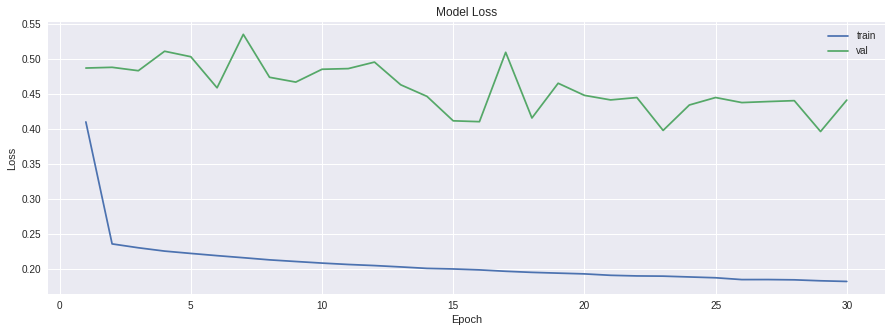

In [0]:
plot_model_history(model_hist.history)

In [0]:
train_preds = GoogleNews_model.predict([X_train['search_term'] , X_train['product_description']])
val_preds = GoogleNews_model.predict([X_val['search_term'] , X_val['product_description']])
test_preds = GoogleNews_model.predict([X_test['search_term'] , X_test['product_description']])

In [0]:
table = load_table()
add_to_table('WordLSTM_GoogleNews', train_preds, val_preds, test_preds, end_time - start_time)
pd.DataFrame.from_dict(table).T

,Test_MAE,Test_RMSE,Train_MAE,Train_RMSE,runtime,val_MAE,val_RMSE
CharacterLSTM,0.439620,0.529653,0.407273,0.490909,344.968230,0.548179,0.666130
LightGBM(1D),0.431425,0.524175,0.392092,0.473328,2.015421,0.573347,0.695735
RandomForest(1D),0.439696,0.542474,0.160088,0.218505,61.621884,0.530739,0.650805
WordLSTM_GoogleNews,0.433116,0.529140,0.347584,0.425105,219.812323,0.516138,0.629872
naïve_model(1C),0.537570,0.724760,0.507341,0.675441,96.343572,0.903160,1.058353
naïve_model_mean(1C),0.440792,0.531097,0.408442,0.489216,106.922296,0.583952,0.706428


In [0]:
# save_table()

We can observed that the model is better then the ```naïve_model_mean``` model with $0.5291$ *RMSE* score on the test set. In addition we see that the model is doing better the all other model on the validation set with $0.629...$ *RMSE* score.<br>
In addition we can see that the ```WordLSTM_GoogleNews``` model fit time were faster than the ```CharacterLSTM```. Again we assume that is because the length of the words sequences is mach smaller the the character sequences. $3$ for the search term search in opposite to $16$. And $142$ for the product description in compared to $730$.

Test
RMSE: 0.5291


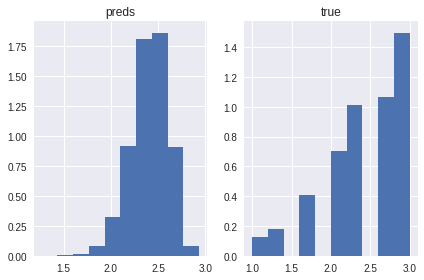

In [0]:
print('Test')
plot_results(test_preds, y_test.values)

In [0]:
test_preds.min(), test_preds.max()

(1.2674831, 2.9339314)

Here we can see that the model predict bigger range of possible values from the ```CharacterLSTM``` model. In addition we can observed that the model pretends around the mean of the train set which is $2.43$. This two factors explain the decrease in the *RMSE* score.

### Second Model - ```embedding_matrix_fastText``` without train it.

In [0]:
fastText_model = get_model(embedding_matrix_fastText)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
term_input (InputLayer)         (None, 3)            0                                            
__________________________________________________________________________________________________
product_input (InputLayer)      (None, 142)          0                                            
__________________________________________________________________________________________________
term_embedding (Embedding)      (None, 3, 300)       52851000    term_input[0][0]                 
__________________________________________________________________________________________________
product_embedding (Embedding)   (None, 142, 300)     52851000    product_input[0][0]              
__________________________________________________________________________________________________
shared_mod

For this model too, we will not want to train the layers embedding.

In [0]:
fastText_model.get_layer('term_embedding').trainable = False
fastText_model.get_layer('product_embedding').trainable = False

optimizer = Adadelta(clipnorm=gradient_clipping_norm)
fastText_model.compile(loss='mse', optimizer=optimizer)
fastText_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
term_input (InputLayer)         (None, 3)            0                                            
__________________________________________________________________________________________________
product_input (InputLayer)      (None, 142)          0                                            
__________________________________________________________________________________________________
term_embedding (Embedding)      (None, 3, 300)       52851000    term_input[0][0]                 
__________________________________________________________________________________________________
product_embedding (Embedding)   (None, 142, 300)     52851000    product_input[0][0]              
__________________________________________________________________________________________________
shared_mod

In [0]:
cp = ModelCheckpoint(path + '/best_model_weights_words_fastText.h5',save_best_only=True)
start_time = time.time()
model_hist = fastText_model.fit([X_train['search_term'], X_train['product_description']], y_train, 
                                validation_data=[[X_val['search_term'], X_val['product_description']], y_val], 
                                epochs=30, batch_size=1024, callbacks=[cp])
end_time = time.time()

Train on 59253 samples, validate on 14814 samples
Epoch 1/30
59253/59253 [==============================] - 7s 110us/step - loss: 0.4119 - val_loss: 0.4567
Epoch 2/30
59253/59253 [==============================] - 6s 102us/step - loss: 0.2391 - val_loss: 0.5043
Epoch 3/30
59253/59253 [==============================] - 6s 103us/step - loss: 0.2320 - val_loss: 0.4778
Epoch 4/30
59253/59253 [==============================] - 6s 102us/step - loss: 0.2257 - val_loss: 0.5088
Epoch 5/30
59253/59253 [==============================] - 6s 100us/step - loss: 0.2211 - val_loss: 0.4817
Epoch 6/30
59253/59253 [==============================] - 6s 100us/step - loss: 0.2180 - val_loss: 0.5058
Epoch 7/30
59253/59253 [==============================] - 6s 100us/step - loss: 0.2150 - val_loss: 0.4780
Epoch 8/30
59253/59253 [==============================] - 6s 100us/step - loss: 0.2122 - val_loss: 0.5140
Epoch 9/30
59253/59253 [==============================] - 6s 99us/step - loss: 0.2098 - val_loss: 0.45

In [0]:
fastText_model.load_weights(path + '/best_model_weights_words_fastText.h5')

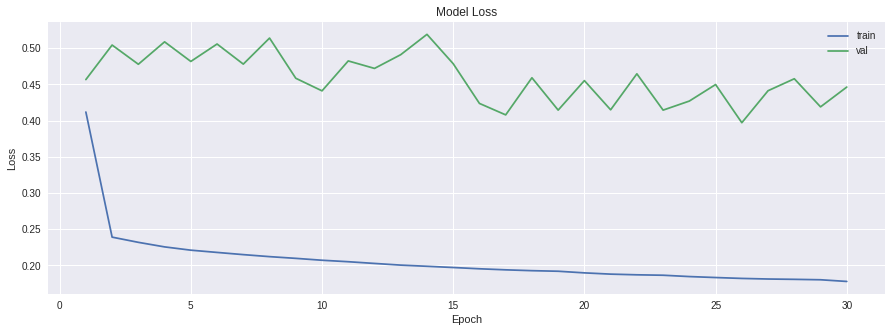

In [0]:
plot_model_history(model_hist.history)

In [0]:
train_preds = fastText_model.predict([X_train['search_term'] , X_train['product_description']])
val_preds = fastText_model.predict([X_val['search_term'] , X_val['product_description']])
test_preds = fastText_model.predict([X_test['search_term'] , X_test['product_description']])

In [0]:
table = load_table()
add_to_table('WordLSTM_fastText', train_preds, val_preds, test_preds, end_time - start_time)
pd.DataFrame.from_dict(table).T

,Test_MAE,Test_RMSE,Train_MAE,Train_RMSE,runtime,val_MAE,val_RMSE
CharacterLSTM,0.439620,0.529653,0.407273,0.490909,344.968230,0.548179,0.666130
LightGBM(1D),0.431425,0.524175,0.392092,0.473328,2.015421,0.573347,0.695735
RandomForest(1D),0.439696,0.542474,0.160088,0.218505,61.621884,0.530739,0.650805
WordLSTM_GoogleNews,0.433116,0.529140,0.347584,0.425105,219.812323,0.516138,0.629872
WordLSTM_fastText,0.437551,0.531828,0.348520,0.424819,211.522421,0.516554,0.630182
naïve_model(1C),0.537570,0.724760,0.507341,0.675441,96.343572,0.903160,1.058353
naïve_model_mean(1C),0.440792,0.531097,0.408442,0.489216,106.922296,0.583952,0.706428


In [0]:
# save_table()

From the table above we can conclude that the ```WordLSTM_fastText``` model is not performing better than the ```WordLSTM_GoogleNews``` model, we see an increase on the *RMSE* score over the test set from $0.5291$ to $0.5318$. And more important it does not perform better than the ```naïve_model_mean(1C)``` over the test set.<br>
In addition, we observed that the *RMSE* score over the train and validation sets are similar to the ```WordLSTM_GoogleNews``` model. From this we conclude that the are more words from the test set paper in the *GoogleNews* embedding matrix and not in the *fastText* embedding matrix.

Test
RMSE: 0.5318


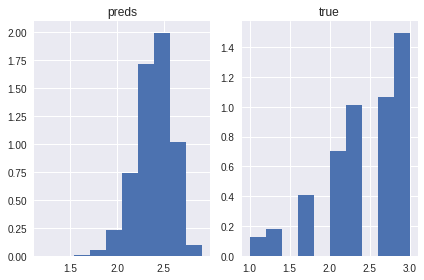

In [0]:
print('Test')
plot_results(test_preds, y_test.values)

In [0]:
test_preds.min(), test_preds.max()

(1.1980585, 2.9054303)

Here we can see that the model is not making a very robust prediction because the target range is smaller than the previous model.

### Third Model - ```embedding_matrix_comb```

In [0]:
comb_model = get_model(embedding_matrix_comb)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
term_input (InputLayer)         (None, 3)            0                                            
__________________________________________________________________________________________________
product_input (InputLayer)      (None, 142)          0                                            
__________________________________________________________________________________________________
term_embedding (Embedding)      (None, 3, 300)       52851000    term_input[0][0]                 
__________________________________________________________________________________________________
product_embedding (Embedding)   (None, 142, 300)     52851000    product_input[0][0]              
__________________________________________________________________________________________________
shared_mod

This time we do want to train the embedding matrix so we just skip ahead and start fighting the model.

In [0]:
cp = ModelCheckpoint(path + '/best_model_weights_words_comb.h5',save_best_only=True)
start_time = time.time()
model_hist = comb_model.fit([X_train['search_term'], X_train['product_description']], y_train, 
                            validation_data=[[X_val['search_term'], X_val['product_description']], y_val], 
                            epochs=30, batch_size=1024, callbacks=[cp])
end_time = time.time()

Train on 59253 samples, validate on 14814 samples
Epoch 1/30
59253/59253 [==============================] - 18s 310us/step - loss: 0.3180 - val_loss: 0.5484
Epoch 2/30
59253/59253 [==============================] - 16s 272us/step - loss: 0.2279 - val_loss: 0.4932
Epoch 3/30
59253/59253 [==============================] - 16s 269us/step - loss: 0.2167 - val_loss: 0.4430
Epoch 4/30
59253/59253 [==============================] - 16s 269us/step - loss: 0.2084 - val_loss: 0.4902
Epoch 5/30
59253/59253 [==============================] - 16s 268us/step - loss: 0.2010 - val_loss: 0.3933
Epoch 6/30
59253/59253 [==============================] - 16s 270us/step - loss: 0.1945 - val_loss: 0.4119
Epoch 7/30
59253/59253 [==============================] - 16s 268us/step - loss: 0.1895 - val_loss: 0.3876
Epoch 8/30
59253/59253 [==============================] - 16s 268us/step - loss: 0.1837 - val_loss: 0.3876
Epoch 9/30
59253/59253 [==============================] - 16s 268us/step - loss: 0.1785 - val_

In [0]:
comb_model.load_weights(path + '/best_model_weights_words_comb.h5')

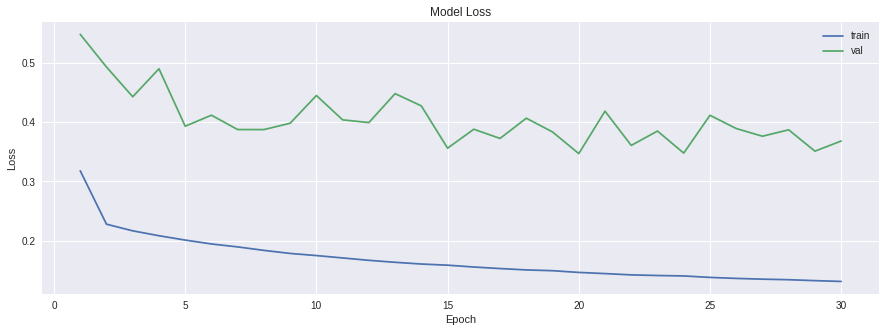

In [0]:
plot_model_history(model_hist.history)

In [0]:
train_preds = comb_model.predict([X_train['search_term'] , X_train['product_description']])
val_preds = comb_model.predict([X_val['search_term'] , X_val['product_description']])
test_preds = comb_model.predict([X_test['search_term'] , X_test['product_description']])

In [0]:
table = load_table()
add_to_table('WordLSTM_comb', train_preds, val_preds, test_preds, end_time - start_time)
pd.DataFrame.from_dict(table).T

,Test_MAE,Test_RMSE,Train_MAE,Train_RMSE,runtime,val_MAE,val_RMSE
CharacterLSTM,0.439620,0.529653,0.407273,0.490909,344.968230,0.548179,0.666130
LightGBM(1D),0.431425,0.524175,0.392092,0.473328,2.015421,0.573347,0.695735
RandomForest(1D),0.439696,0.542474,0.160088,0.218505,61.621884,0.530739,0.650805
WordLSTM_GoogleNews,0.433116,0.529140,0.347584,0.425105,219.812323,0.516138,0.629872
WordLSTM_comb,0.439856,0.536867,0.311176,0.380940,590.085942,0.482452,0.589099
WordLSTM_fastText,0.437551,0.531828,0.348520,0.424819,211.522421,0.516554,0.630182
naïve_model(1C),0.537570,0.724760,0.507341,0.675441,96.343572,0.903160,1.058353
naïve_model_mean(1C),0.440792,0.531097,0.408442,0.489216,106.922296,0.583952,0.706428


In [0]:
# save_table()

From the table we can observe the following:
1. The model runtime is the the highest. Observed that it is expected since we train a lot more weights $105,778,928$ to be exact, and so far we train at most $76,928$ weights.
2. The model performance on the test set are pretty bad comparing to the ```naïve_model_mean``` model. With $0.5368$ *RMSE* score on the test set.
3. It can be said clearly that this is the worst model of the three who wanted to check.<br>

We think all of those think happened because we combine to embedding matrices that were nothing a like.In addition we suspect that we don't have enough samples to train on relative to the amount of weights that must be trained.

Test
RMSE: 0.5369


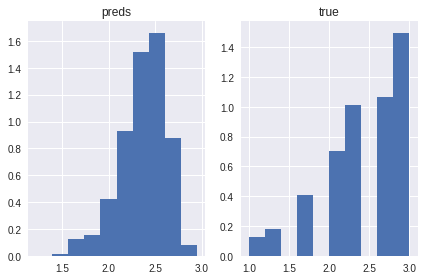

In [0]:
print('Test')
plot_results(test_preds, y_test.values)

In [0]:
test_preds.min(), test_preds.max()

(1.2196696, 2.9475996)

### Comparison Of The Words Embedding Models

In [0]:
pd.DataFrame.from_dict(table).drop(set(table.keys() - set(['WordLSTM_GoogleNews', 'WordLSTM_comb', 'WordLSTM_fastText'])), axis=1).T

,Test_MAE,Test_RMSE,Train_MAE,Train_RMSE,runtime,val_MAE,val_RMSE
WordLSTM_GoogleNews,0.433116,0.529140,0.347584,0.425105,219.812323,0.516138,0.629872
WordLSTM_comb,0.439856,0.536867,0.311176,0.380940,590.085942,0.482452,0.589099
WordLSTM_fastText,0.437551,0.531828,0.348520,0.424819,211.522421,0.516554,0.630182


From this limited table we can observed that the *GoogleNews* model as the best *RMSE* and *MAE* on the test set. In addition we can see that the *GoogleNews* model and the *fastText* model as almost the same result over all the measurements except the *RMSE* score on the test set. As we matched before we think that is because ther are more words from the test set that as a representation in the in the *GoogleNews* matrix and don't hase on in the *fastText* matrix.<br>
At first this observation seemed abit strange to us in the context of the test *MAE* score.So we started to thinking about a good reasonable explanation for this. Clearly it as something to do with the mathematical definitions of those functions.<br>

So let's observe the similarities and differences between the two.<br>
> *MAE* - Mean Absolute Error
\begin{align}
MAE = \frac{1}n\sum_{i=1}^n|(y_i-\hat{y_i})| \\
\end{align}
*MAE* measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.<br>

> *RMSE* - Root mean squared error
\begin{align}
RMSE = \sqrt{\frac{1}n\sum_{i=1}^n(y_i-\hat{y_i})^2} \\
\end{align}
*RMSE* is a quadratic scoring rule that also measures the average magnitude of the error. It’s the square root of the average of squared differences between prediction and actual observation.<br>

This means that the both functions express average model prediction error in units of the variable of interest. Both metrics can range from $0$ to $\infty$ and are indifferent to the direction of errors. They are negatively-oriented scores, which means lower values are better.<br>
In addition, taking the square root of the average squared errors has some interesting implications for *RMSE*. Since the errors are squared before they are averaged, the *RMSE* gives a relatively ***high weight to large errors***. This means the *RMSE* should be more useful when large errors are particularly undesirable.<br>

Now that we know a lot more about each metric we can see that the "strange observation" we saw earlier is actually making a lot of sense. It's point out that the model with the lowest *RMSE*, is much better. Which leads me to conclude that the best model of the three is ```WordLSTM_GoogleNews``` model.

## C - Feature Extractor

As we just saw the best model from the privasl section is the ```WordLSTM_GoogleNews``` model. So we will use it as feature extractor.<br>
To do that we will create the same model, and load to it the trained weights. <br>After that we will cut the last layer in the model. In order to use it's output as features to a ML model.<br>
As in section $1D$, after we cut the last layer we left with $2$ ouputs due to the siamese network architecture. So we will add a ```concatenate``` layer.

In [0]:
def make_model_for_FE(best_model_weights_file_name, embedding_matrix):
  # Input
  term_input = Input(shape=(search_terms_lens,), name='term_input')
  product_input = Input(shape=(produc_lens,), name='product_input')


  # Embedding
  term_embedding = Embedding(embedding_matrix.shape[0], 300, weights=[embedding_matrix], 
                             input_length=search_terms_lens, name='term_embedding')(term_input)

  product_embedding = Embedding(embedding_matrix.shape[0], 300, weights=[embedding_matrix], 
                             input_length=produc_lens, name='product_embedding')(product_input)

  # Shared LSTM
  shared_lstm = Sequential(name='shared_model')
  shared_lstm.add(CuDNNLSTM(lstm_n_hidden))
  shared_lstm.add(Dense(128, activation='relu'))

  # Output
  output = concatenate([shared_lstm(term_embedding), shared_lstm(product_embedding)])

  model = Model(inputs=[term_input, product_input], outputs=[output])
  model.load_weights(path + '/' + best_model_weights_file_name)
  optimizer = Adadelta(clipnorm=gradient_clipping_norm)
  model.compile(loss='mse', optimizer=optimizer)
  model.summary()
  
  return model

In [20]:
fe_model = make_model_for_FE('best_model_weights_words_GoogleNews.h5', embedding_matrix_GoogleNews)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
term_input (InputLayer)         (None, 3)            0                                            
__________________________________________________________________________________________________
product_input (InputLayer)      (None, 142)          0                                            
__________________________________________________________________________________________________
term_embedding (Embedding)      (None, 3, 300)       52851000    term_input[0][0]                 
__________________________________________________________________________________________________
product_embedding (Embedding)   (None, 142, 300)     52851000    product_input[0][0]              
__________________________________________________________________________________________________
shared_mod

In [0]:
train_features = fe_model.predict([X_train['search_term'] , X_train['product_description']])
val_features = fe_model.predict([X_val['search_term'] , X_val['product_description']])
test_features = fe_model.predict([X_test['search_term'] , X_test['product_description']])

### KNN

In [0]:
neigh = KNeighborsRegressor(n_neighbors=10)
start_time = time.time()
neigh.fit(train_features, y_train)
end_time = time.time()

In [0]:
train_preds = neigh.predict(train_features)
val_preds = neigh.predict(val_features)
test_preds = neigh.predict(test_features)

In [0]:
table = load_table()
add_to_table('KNN(2C)', train_preds, val_preds, test_preds, end_time - start_time)
pd.DataFrame.from_dict(table).T

,Test_MAE,Test_RMSE,Train_MAE,Train_RMSE,runtime,val_MAE,val_RMSE
CharacterLSTM,0.439620,0.529653,0.407273,0.490909,344.968230,0.548179,0.666130
KNN(2C),0.435815,0.561551,0.329773,0.423078,16.907317,0.591294,0.727415
LightGBM(1D),0.431425,0.524175,0.392092,0.473328,2.015421,0.573347,0.695735
RandomForest(1D),0.439696,0.542474,0.160088,0.218505,61.621884,0.530739,0.650805
WordLSTM_GoogleNews,0.433116,0.529140,0.347584,0.425105,219.812323,0.516138,0.629872
WordLSTM_comb,0.439856,0.536867,0.311176,0.380940,590.085942,0.482452,0.589099
WordLSTM_fastText,0.437551,0.531828,0.348520,0.424819,211.522421,0.516554,0.630182
naïve_model(1C),0.537570,0.724760,0.507341,0.675441,96.343572,0.903160,1.058353
naïve_model_mean(1C),0.440792,0.531097,0.408442,0.489216,106.922296,0.583952,0.706428


In [0]:
# save_table()

We can see that the ```KNN``` model did worse than the ```naïve_model_mean``` model on the test and validation set. Since the ```KNeighborsRegressor``` predicts the means of the $13$ nearest neighbors, this mean that the the samples that has the some target are not so close to each other. So the mean of the $13$ nearest neighbors is very different from the real target value. Which shows as a significant increase in the *RMSE* score.

Test
RMSE: 0.5616


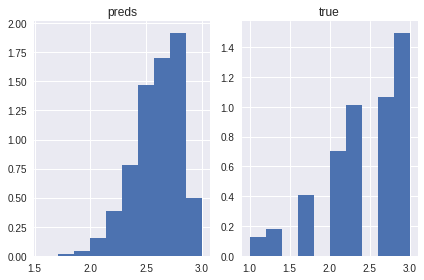

In [0]:
print('Test')
plot_results(test_preds, y_test.values)

In [0]:
test_preds.min(), test_preds.max()

(1.5638461538461537, 3.0)

### XGBRegreesor
Boosting is an ensemble technique in which the predictors are not made independently, but sequentially.<br>
We will choose two parameters, one is objective -this defines the loss function to be minimized, in our case we wil define the task as linear regression.<br>
The second parameter is random state which is just a random seed.

In [0]:
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)
xgb_model,end_time = time_to_fit(xgb_model,train_features, y_train)

In [8]:
train_preds = xgb_model.predict(train_features)
val_preds = xgb_model.predict(val_features)
test_preds = xgb_model.predict(test_features)

table = load_table()
add_to_table('XGboost', train_preds, val_preds, test_preds, end_time)
pd.DataFrame.from_dict(table).T

,Test_MAE,Test_RMSE,Train_MAE,Train_RMSE,runtime,val_MAE,val_RMSE
CharacterLSTM,0.439620,0.529653,0.407273,0.490909,344.968230,0.548179,0.666130
KNN(2C),0.435815,0.561551,0.329773,0.423078,16.907317,0.591294,0.727415
LightGBM(1D),0.431425,0.524175,0.392092,0.473328,2.015421,0.573347,0.695735
RandomForest(1D),0.439696,0.542474,0.160088,0.218505,61.621884,0.530739,0.650805
WordLSTM_GoogleNews,0.433116,0.529140,0.347584,0.425105,219.812323,0.516138,0.629872
WordLSTM_comb,0.439856,0.536867,0.311176,0.380940,590.085942,0.482452,0.589099
WordLSTM_fastText,0.437551,0.531828,0.348520,0.424819,211.522421,0.516554,0.630182
XGboost,0.426094,0.523689,0.355703,0.435466,40.314034,0.542750,0.662430
naïve_model(1C),0.537570,0.724760,0.507341,0.675441,96.343572,0.903160,1.058353
naïve_model_mean(1C),0.440792,0.531097,0.408442,0.489216,106.922296,0.583952,0.706428


We can see, that the XGboost using after feature extraction did good with the Word lstm model result.<br>
Actualy, the  LSTM RMSE score went form 0.529.. $ \to $ 0.523.. 
Another improvment  can be seen in the comparison with the naive mean model.
XGBoost training is just 40 seconds which is pretty fast compare to other models.

In [0]:
save_table()

RMSE: 0.5237


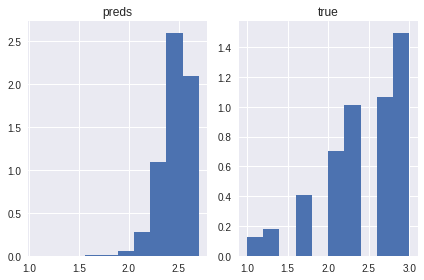

In [10]:
plot_results(test_preds, y_test.values)

## D - Results Comparison  

In [11]:
table = load_table()
pd.DataFrame.from_dict(table).T

,Test_MAE,Test_RMSE,Train_MAE,Train_RMSE,runtime,val_MAE,val_RMSE
CharacterLSTM,0.439620,0.529653,0.407273,0.490909,344.968230,0.548179,0.666130
KNN(2C),0.435815,0.561551,0.329773,0.423078,16.907317,0.591294,0.727415
LightGBM(1D),0.431425,0.524175,0.392092,0.473328,2.015421,0.573347,0.695735
RandomForest(1D),0.439696,0.542474,0.160088,0.218505,61.621884,0.530739,0.650805
WordLSTM_GoogleNews,0.433116,0.529140,0.347584,0.425105,219.812323,0.516138,0.629872
WordLSTM_comb,0.439856,0.536867,0.311176,0.380940,590.085942,0.482452,0.589099
WordLSTM_fastText,0.437551,0.531828,0.348520,0.424819,211.522421,0.516554,0.630182
XGboost,0.426094,0.523689,0.355703,0.435466,40.314034,0.542750,0.662430
naïve_model(1C),0.537570,0.724760,0.507341,0.675441,96.343572,0.903160,1.058353
naïve_model_mean(1C),0.440792,0.531097,0.408442,0.489216,106.922296,0.583952,0.706428


We already talked alot of the results after each stage, so we will relate mainly two the best models of the two sections.<br>
Char level best model is lightGBM with 0.524.. test RMSE score compare to the word level best model which is XGboost with test RMSE score 0.523.. <br>
There is no big difference between the two which can't point on difference between char and word levels represntation.<br>
Surprisingly the feature extraction did succeed to improve the results of both of the LSTM models. 

# Section 3

## Summary

*Introduction*
>In this research we worked with the Home depot product search relevance competition dataset. The competition took place some 3 years ago. And the goal has to state the relevance of a search phrase to a corresponding item; in order to rank batter the results of a search engine for Home-Depot’s items.
The relevance is a number between 1 (not relevant) to 3 (highly relevant). Each pair of search term and product discerption was evaluated by at least three human raters. The relevance scores are the average value of the ratings.
This research had two main stages. The main different between the two was how we represented the input. In one we represented the inputs as sequences of single characters. And the other as sequences of words.

*Data Exploration*
>We started the research by exploring the dataset. The main thing that we found out is that the data is not balanced. This means that we had more samples with target value in range of 2 to 3 then targets in range 1 to 2. In order to overcame this problem we decided to not split the train file into train and validation set randomly and instead we have splited all the samples with relevance below 2, equally (and randomly) between the train and validation set.
Another thing that we found was that some of the samples of the train set are to be ignored. Notice that we had the relevance to the test set because this competition ended 3 years ago. So as a preprocess stage we remove all of those samples. First we though that it will make our test set very small but after applying the filtering we discovered that the test set contain 83,447 samples which is more than the train and validation sets together.

*Preprocess*
>In the research we did two pre-processes one for each stage of the research. In both we used the keras.Tokenaizer implementation as a label encoder. Notice that by only using label encoder we ranking the tokens. That is, if the char ‘a’ is encodes as to 1 and the char ‘b’ encoded as 2 than the model can learn that $1 < 2$ which is not true for ‘a’ and 'b’.
For the characters stage of the research we do not solve this problem. But in the words we use embedding to address this. That is because we thought that the model can overcome the “ranking problem” because there are a lot of occurrences of the same char in the train. For the words stage of the research we use pre-trained embedding vectors.

*Architecture*
>In both of the research stages we use siamese networks architecture. This is a model that can be seen as two other models that has the same architecture and shared weights. which combined together to usually to find similarity. And sense our task is to find similarity between the search term and the product description, which is a task that match this architecture. In addition sense after the pre-process we have sequences of chars \ words we though it will be best to use a LSTM layers such that the “time dimension” is the char \ words.

*Conclusion*
> We saw that there are not much different between characters and words we saw that if we compare the best model of the each stage we get pretty much the same results. In addition we learn a lot about siamese networks and the different between the RMSE and MAE matrices. For future work we recommend to use embedding for character which we didn’t have the time to experiment with. In addition we also like to recommend to finding or training better embedding of words.